In [1]:
import numpy as np
from pandas_plink import read_plink
from limix_lmm import LMM
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests
import seaborn as sns

In [2]:
import scipy
import scipy.stats as st

if not hasattr(scipy, 'dot'):
    scipy.dot = np.dot
if not hasattr(scipy, 'einsum'):
    scipy.einsum = np.einsum
if not hasattr(scipy, 'log'):
    scipy.log = np.log
if not hasattr(scipy, 'sign'):
    scipy.sign = np.sign
if not hasattr(scipy, 'sqrt'):
    scipy.sqrt = np.sqrt

INITIAL:

Number of variants: 109827 

Number of samples: 2504

AFTER QC:

Number of variants: 59743

Number of samples: 2504


In [3]:
#bfile = '/Users/oykusuoglu/gobi/gobi_gwas/oyku/data/qc/chr22_step3_sampleqc'
bfile = '/Users/oykusuoglu/gobi/gobi_gwas/oyku/data/pca/before_qc/qc/chr22_step3_sampleqc'
bim, fam, G = read_plink(bfile)

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 48.97it/s]
/opt/anaconda3/envs/gobi_venv/lib/python3.10/site-packages/pandera/_pandas_deprecated.py:146: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


In [4]:
n_snps = bim.shape[0]
n_samples = fam.shape[0]
n_snps, n_samples

(59743, 2504)

In [5]:
X_real = G.compute().T

In [6]:
X_real.shape

(2504, 59743)

Standardize the genotype matrix, so that all SNPs are on the same scale, 3 variants were dropped, which had a standard deviation equals to 0 among all individuals. (bim annotation table must be also updated)

In [7]:
#whole chromosome 22

mu_full = X_real.mean(axis=0)
sd_full = X_real.std(axis=0, ddof=0)
keep_full = sd_full > 1e-12
keep_idx  = np.where(keep_full)[0] 
standardized_X = (X_real[:, keep_full] - mu_full[keep_full]) / sd_full[keep_full]

In [8]:
# bim data for variants that werent dropped after the standardization
bim_kept = bim.iloc[keep_idx].copy().reset_index(drop=True)

bim_kept["orig_bim_idx"] = keep_idx

In [9]:
X_real.shape

(2504, 59743)

In [10]:
standardized_X.shape

(2504, 59740)

### Phase 1: Phenotype Simulation

First, we need to set the parameters (heritability and number of casual SNPs):

In [11]:

M = 10 
h2 = 0.6 

rng = np.random.default_rng(42)
idx_caus = rng.choice(standardized_X.shape[1], size=M, replace=False)
var_expl = np.repeat(h2/M, M)

Code from GWAS exercise to simulate phenotypes (maybe delete the standardization part from here since its been done beforehand):

In [12]:
def simulate_pheno(X, idx_caus, var_expl, rng, direction=None):
    # Ensure that the number of causal variant indices matches the number of variances explained.
    assert len(idx_caus) == len(var_expl)

    # If no direction is provided, randomly assign a positive or negative direction for each causal variant.
    if direction is None:
        direction = 2. * (rng.random(len(idx_caus)) > 0.5) - 1.
    # Ensure that the number of directions matches the number of causal variant indices.
    assert len(idx_caus) == len(direction)

    # Compute the remaining variance after accounting for the variance explained by the causal variants.
    ve = 1 - var_expl.sum()
    # Ensure that the total variance explained by causal variants is less than 1.
    assert ve > 0, 'sum(var_expl) should be < 1'

    # Compute the effect sizes for the causal variants based on the variance they explain and their direction.
    beta = np.sqrt(var_expl) * direction

    # Extract the columns of X corresponding to the causal variants and standardize them.
    Xc = X[:, idx_caus]
    Xc = (Xc - Xc.mean(0)) / Xc.std(0)

    # Compute the genetic component of the phenotype.
    yg = Xc.dot(beta)[:, None]
    # Compute the noise component of the phenotype.
    yn = np.sqrt(ve) * rng.standard_normal((X.shape[0], 1))

    # Sum the genetic and noise components to get the simulated phenotype.
    y = yg + yn

    # Initialize the real effect sizes for all variants in X as zeros.
    beta_real = np.zeros(X.shape[1])
    # Update the real effect sizes for the causal variants.
    beta_real[idx_caus] = beta

    # Standardize the phenotypic values to have mean 0 and standard deviation 1.
    ystd = y.std()
    y = (y - y.mean()) / ystd
    # Adjust the real effect sizes accordingly after standardizing y.
    beta_real = beta_real / ystd

    return y, beta_real

In [13]:
def qq_plot(p_values, title):
    """
    Create a QQ plot given a list of p-values.

    Parameters:
    - p_values: list of p-values
    - title: title for the plot
    """

    # Sort p-values
    observed = -np.log10(np.sort(p_values))
    expected = -np.log10(np.arange(1, len(p_values) + 1) / (len(p_values) + 2))

    # Create the QQ plot
    plt.scatter(expected, observed, marker='.')
    plt.plot([0, max(expected)], [0, max(expected)], color='red', linestyle='--')
    plt.xlabel('Expected -log10(P-value)')
    plt.ylabel('Observed -log10(P-value)')
    plt.title(title)

Apply the code:

In [14]:
y, beta_real = simulate_pheno(standardized_X, idx_caus, var_expl, rng)

In [15]:
y.shape

(2504, 1)

##### LD Pruning for PCA & PCA

Merge the PCs with phenotypes

##### 1) build phenotype table with IDs

In [16]:
pheno = fam[["fid","iid"]].copy()
pheno.columns = ["FID","IID"]
pheno["y"] = y.reshape(-1)

##### 2) load PCs and merge

In [17]:
pc_path = "/Users/oykusuoglu/gobi/gobi_gwas/oyku/data/pca/before_qc/chr22_raw_pca10.eigenvec.zscore"
pcs = pd.read_csv(pc_path, sep=r"\s+", header=0, engine="python")
pcs.columns = ["FID","IID"] + [f"PC{i}" for i in range(1, pcs.shape[1]-1)]

df = pheno.merge(pcs, on=["FID","IID"], how="inner", validate="one_to_one")

##### 3) build F (intercept + PCs) for LMM

In [18]:
k = 10
F = np.column_stack([np.ones((df.shape[0], 1)),
                     df[[f"PC{i}" for i in range(1, k+1)]].to_numpy()])

In [19]:
assert len(fam) == standardized_X.shape[0]

### Phase 2: GWAS / Feature Selection

Now we have:

- our genotype matrix **`standardized_X`** which was first standardized (before that it was **`X_real`**) and then used to simulate the phenotype matrix
- our simulated phenotype matrix **`y`** 
- our covariates (PCs) **`F`**

#### 1. Training/Validation Set Split

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
idx = np.arange(len(fam))

idx_train, idx_test = train_test_split(idx, test_size=0.3, random_state=42, shuffle=True)

train_ids = fam.loc[idx_train, ["fid","iid"]].copy()
test_ids  = fam.loc[idx_test,  ["fid","iid"]].copy()


train_ids.to_csv("/Users/oykusuoglu/gobi/gobi_gwas/oyku/data/splits/train.keep",
                 sep="\t", index=False, header=False)
test_ids.to_csv("/Users/oykusuoglu/gobi/gobi_gwas/oyku/data/splits/test.keep",
                sep="\t", index=False, header=False)
                

X_train = standardized_X[idx_train]
X_test  = standardized_X[idx_test]
y_train = y[idx_train]
y_test  = y[idx_test]
F_train = F[idx_train]
F_test  = F[idx_test]

In [22]:
X_train.shape, y_train.shape, F_train.shape

((1752, 59740), (1752, 1), (1752, 11))

#### 1.2 Clumping only with training individuals


In [23]:
%%bash
set -euo pipefail

BFILE="/Users/oykusuoglu/gobi/gobi_gwas/oyku/data/pca/before_qc/qc/chr22_step3_sampleqc"
KEEP="/Users/oykusuoglu/gobi/gobi_gwas/oyku/data/splits/train.keep"
OUT="/Users/oykusuoglu/gobi/gobi_gwas/oyku/data/splits/chr22_train"

mkdir -p "$(dirname "$OUT")"

plink --bfile "$BFILE" \
  --keep "$KEEP" \
  --make-bed \
  --out "$OUT"

PLINK v1.9.0-b.7.11 64-bit (19 Aug 2025)           cog-genomics.org/plink/1.9/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /Users/oykusuoglu/gobi/gobi_gwas/oyku/data/splits/chr22_train.log.
Options in effect:
  --bfile /Users/oykusuoglu/gobi/gobi_gwas/oyku/data/pca/before_qc/qc/chr22_step3_sampleqc
  --keep /Users/oykusuoglu/gobi/gobi_gwas/oyku/data/splits/train.keep
  --make-bed
  --out /Users/oykusuoglu/gobi/gobi_gwas/oyku/data/splits/chr22_train

16384 MB RAM detected; reserving 8192 MB for main workspace.
59743 variants loaded from .bim file.
2504 people (0 males, 0 females, 2504 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
/Users/oykusuoglu/gobi/gobi_gwas/oyku/data/splits/chr22_train.nosex .
--keep: 1752 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1752 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031

#### 2. GWAS

GWAS is only peformed on the training set (training genotype matrix **`X_train`** and phenotype matrix **`y_train`**)

In [24]:
lmm = LMM(y_train, F_train)
lmm.process(X_train)
pv = lmm.getPv()
beta = lmm.getBetaSNP()
beta_ste = lmm.getBetaSNPste()

In [25]:
pv.shape

(59740,)

In [26]:
np.isnan(pv).any(), np.isnan(pv).sum(), np.where(np.isnan(pv)) 

(False, 0, (array([], dtype=int64),))

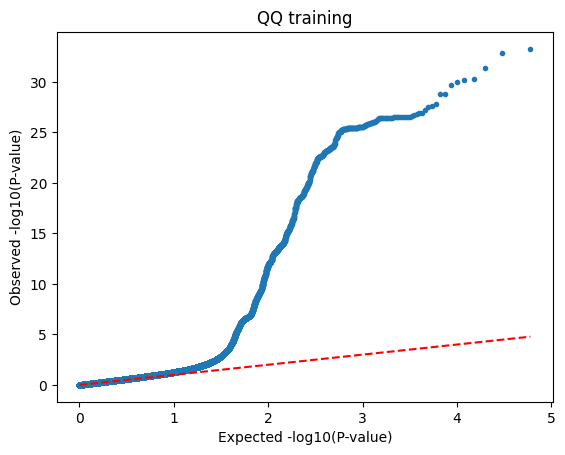

In [27]:
qq_plot(pv, 'QQ training')
plt.show()

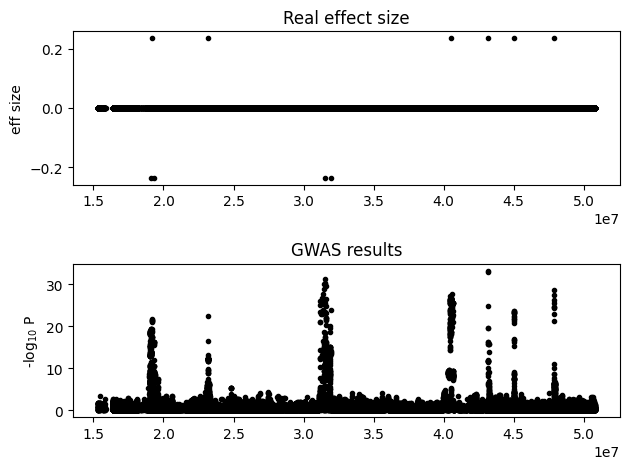

In [28]:
x = bim_kept['pos'].values
plt.subplot(211)
plt.title('Real effect size')
plt.plot(x, beta_real, '.k')
plt.ylabel('eff size')
plt.subplot(212)
plt.title('GWAS results')
plt.plot(x, -np.log10(pv), '.k')
plt.ylabel('-log$_{10}$ P')
plt.tight_layout()
plt.show()

#### 3. Clumping using PLINK 

First create a file with SNP ids and their corresponding p-values

In [29]:
gwas_for_clump = pd.DataFrame({
    "SNP": bim_kept["snp"].astype(str),   
    "P": np.asarray(pv, dtype=float)
})
gwas_for_clump.to_csv("gwas_for_clump.txt", sep="\t", index=False)

In [30]:
%%bash
set -euo pipefail

TRAIN_BFILE="/Users/oykusuoglu/gobi/gobi_gwas/oyku/data/splits/chr22_train"
GWAS_FOR_CLUMP="/Users/oykusuoglu/gobi/gobi_gwas/oyku/notebooks/gwas_for_clump.txt"

plink \
  --bfile "$TRAIN_BFILE" \
  --clump "$GWAS_FOR_CLUMP" \
  --clump-snp-field SNP \
  --clump-field P \
  --clump-p1 1e-4 \
  --clump-p2 1e-2 \
  --clump-r2 0.1 \
  --clump-kb 250 \
  --out "/Users/oykusuoglu/gobi/gobi_gwas/oyku/data/splits/chr22_train_clumped"


PLINK v1.9.0-b.7.11 64-bit (19 Aug 2025)           cog-genomics.org/plink/1.9/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /Users/oykusuoglu/gobi/gobi_gwas/oyku/data/splits/chr22_train_clumped.log.
Options in effect:
  --bfile /Users/oykusuoglu/gobi/gobi_gwas/oyku/data/splits/chr22_train
  --clump /Users/oykusuoglu/gobi/gobi_gwas/oyku/notebooks/gwas_for_clump.txt
  --clump-field P
  --clump-kb 250
  --clump-p1 1e-4
  --clump-p2 1e-2
  --clump-r2 0.1
  --clump-snp-field SNP
  --out /Users/oykusuoglu/gobi/gobi_gwas/oyku/data/splits/chr22_train_clumped

16384 MB RAM detected; reserving 8192 MB for main workspace.
59743 variants loaded from .bim file.
1752 people (0 males, 0 females, 1752 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
/Users/oykusuoglu/gobi/gobi_gwas/oyku/data/splits/chr22_train_clumped.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1752 founders and 0 nonfounders present

clump-p1: p-val threshold for index SNPs
clump-p2: secondary p val threshold for SNPs
clump-r2: LD threshold for joining a SNP to an index SNPs clump 
clump-kb: window radius around the index SNP 

can try playing around with the parameter

In [31]:
# snp IDs used in GWAS (aligned with pv)
snps_gwas = set(bim["snp"].astype(str))   

# SNP IDs in PLINK reference
bim_ref = pd.read_csv("/Users/oykusuoglu/gobi/gobi_gwas/oyku/data/pca/before_qc/qc/chr22_step3_sampleqc.bim", sep=r"\s+", header=None)
bim_ref.columns = ["chrom","snp","cm","pos","a1","a2"]
snps_ref = set(bim_ref["snp"].astype(str))

missing = snps_gwas - snps_ref
print("missing in plink ref:", len(missing))



missing in plink ref: 0


In [32]:
clumped = pd.read_csv("/Users/oykusuoglu/gobi/gobi_gwas/oyku/data/splits/chr22_train_clumped.clumped", sep=r"\s+", engine="python")
lead_snps = clumped["SNP"].astype(str).tolist()

In [33]:
len(lead_snps), lead_snps[:5]

(41, ['rs138948', 'rs5753682', 'rs4823720', 'rs200742767', 'rs79618726'])

In [34]:
snp_to_col = pd.Series(index=bim_kept["snp"].astype(str), data=range(bim_kept.shape[0]))
cols = snp_to_col.reindex(lead_snps).dropna().astype(int).to_numpy()
cols


array([41659, 25870, 51289, 39161, 25612, 26215, 46219, 12035,  5347,
        5138,  5615, 26153, 25958, 25592,  4907,  4926,  6018, 41738,
        5633, 51398,  5409, 41667, 51295, 41695, 15253, 25616,  4653,
        5211, 11957, 41795, 38913, 39092, 11814, 46217, 20646, 25793,
       19260, 50550, 32999,  5432, 12201])

In [35]:
# Which causal variants made it into your lead SNPs?
causal_snp_names = set(bim_kept.iloc[idx_caus]["snp"].astype(str))
recovered = causal_snp_names.intersection(set(lead_snps))
print(f"Directly recovered: {len(recovered)}/10 causal variants")

Directly recovered: 4/10 causal variants


In [36]:
# For each causal variant NOT in lead_snps, find its LD with lead SNPs
causal_not_recovered = causal_snp_names - set(lead_snps)

# Check if any lead SNP is within the clumping window (250kb) of these causal variants
for snp in causal_not_recovered:
    causal_pos = bim_kept[bim_kept["snp"] == snp]["pos"].values[0]
    nearby_leads = [ls for ls in lead_snps 
                    if abs(bim_kept[bim_kept["snp"] == ls]["pos"].values[0] - causal_pos) < 250000]
    print(f"{snp}: {len(nearby_leads)} lead SNPs within 250kb")

rs77426923: 2 lead SNPs within 250kb
rs75667314: 9 lead SNPs within 250kb
rs5993577: 7 lead SNPs within 250kb
rs738655: 3 lead SNPs within 250kb
rs2800959: 10 lead SNPs within 250kb
rs12160875: 2 lead SNPs within 250kb


In [37]:
X_clump_train = X_train[:, cols] 
X_clump_test = X_test[:, cols]   

### Phase 3: Model Development

Train a regression model to predict the phenotype based on the selected SNPs and test it on the
validation set

In [38]:
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error


**`X_clump_train`**: training genotype matrix only including clumped SNPs

**`X_clump_test`**: test genotype matrix only including clumped SNPs

**`y_train`**: training phenotypes

**`y_test`**: test phenotypes


In [39]:
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

In [40]:
regr = linear_model.LinearRegression()
regr.fit(X_clump_train, y_train)

y_pred = regr.predict(X_clump_test)

R2: close to 1 ~ good performance

MSE: close to 0 ~ good performance 

spearman r: 
- close to -1 ~ monotonic negative correlation
- close to 1 ~ monotonic positive correlation


In [41]:
from scipy import stats
spearman = stats.spearmanr(y_test, y_pred)
print("R2", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("spearman r: ", spearman.statistic)

R2 0.5855489162429439
MSE: 0.42996063841030074
spearman r:  0.761766431173061


In [42]:
def plot_prediction(y_pred, input, model):
    plt.scatter(y_test, y_pred)

    xx = np.linspace(y_pred.min(), y_pred.max(), 200)

    plt.plot(xx, xx, linewidth=2, linestyle="--", label="ideal: y=x", color="orange")
    plt.title(f"{model} with {input}")
    plt.xlabel("Phenotype true")
    plt.ylabel("Phenotype predicted")
    plt.show()

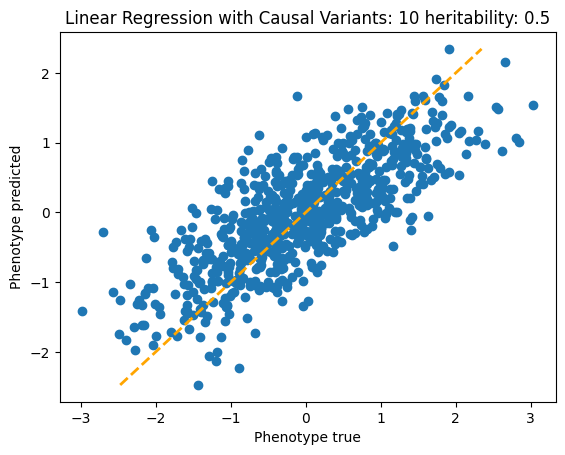

In [43]:
plot_prediction(y_pred, input="Causal Variants: 10 heritability: 0.5", model="Linear Regression")

In [44]:
X_train_w_pcs = np.hstack([X_clump_train, F_train[:, 1:]])  # F[:, 1:] excludes intercept
X_test_w_pcs = np.hstack([X_clump_test, F_test[:, 1:]])

regr.fit(X_train_w_pcs, y_train)
y_pred_w_pcs = regr.predict(X_test_w_pcs)

In [45]:
spearman_w_pcs = stats.spearmanr(y_test, y_pred_w_pcs)
print("R2", r2_score(y_test, y_pred_w_pcs))
print("MSE:", mean_squared_error(y_test, y_pred_w_pcs))
print("spearman r: ", spearman_w_pcs.statistic)

R2 0.5821216833480947
MSE: 0.4335161249350119
spearman r:  0.7601441981175786


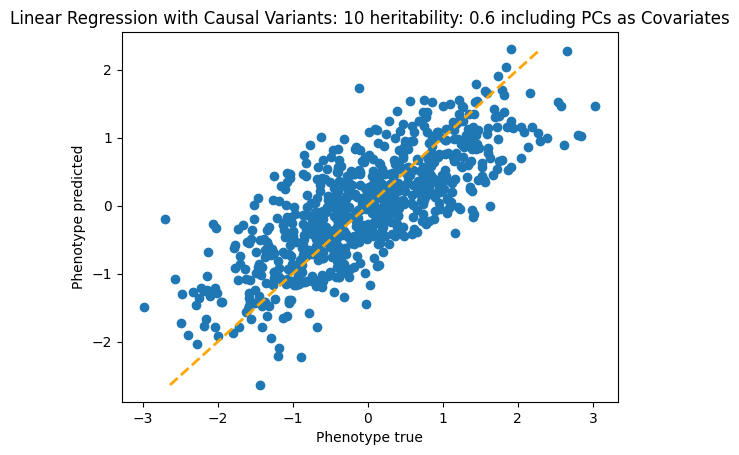

In [46]:
plot_prediction(y_pred_w_pcs, input="Causal Variants: 10 heritability: 0.6 including PCs as Covariates", model="Linear Regression")

#### Predict with Multi Layer Perceptron

In [47]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    hidden_layer_sizes=(8, 16),
    activation="relu",
    max_iter=1000,
    alpha=0.001,
    beta_1=0.5,
    random_state=42
    )

In [48]:
mlp.fit(X_train_w_pcs, y_train)
y_pred_w_mlp = mlp.predict(X_test_w_pcs)

In [49]:
spearman_w_mlp = stats.spearmanr(y_test, y_pred_w_mlp)
print("R2", r2_score(y_test, y_pred_w_mlp))
print("MSE:", mean_squared_error(y_test, y_pred_w_mlp))
print("spearman r: ", spearman_w_mlp.statistic)

R2 0.439261957673577
MSE: 0.5817219356119163
spearman r:  0.6777246906642066


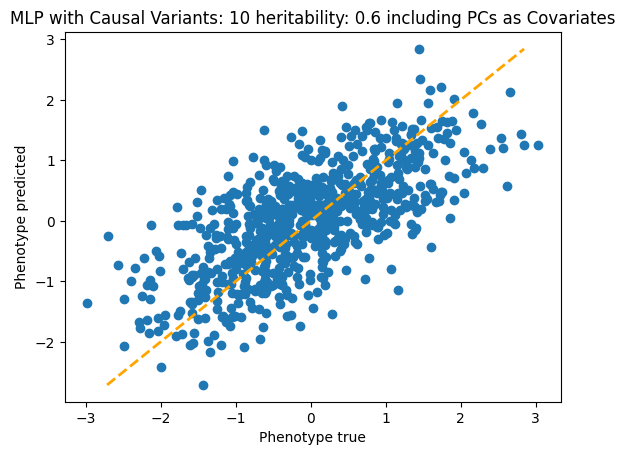

In [50]:
plot_prediction(y_pred_w_mlp, input="Causal Variants: 10 heritability: 0.6 including PCs as Covariates", model="MLP")